In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import os
import networkx as nx
import seaborn as sns


from numpy.linalg import eigh
from scipy import sparse as sp
from scipy.sparse import issparse
from matplotlib import pyplot as plt
from collections import defaultdict
from functools import reduce

from sklearn.cluster import KMeans
from scipy.sparse.linalg import eigs

from helpers import (
    signed_layout, draw_nodes, draw_edges, flatten, 
    dict2array, signed_group_conductance,
    conductance_by_sweeping,
    get_borderless_fig, 
    labels2groups,
    num_ccs, cc_sizes
) 
from sweeping import sweeping_scores_using_ppr
from motif_adjacency import motif_eef_anchored, motif_fff, motif_ff

# graph transformation

In [3]:
g = nx.Graph()
g.add_edges_from([
    (0, 1, {'sign': 1}),
    (1, 2, {'sign': -1}),
    (0, 2, {'sign': -1}),
])

In [4]:
A = nx.adjacency_matrix(g, weight='sign')
A.todense()

matrix([[ 0,  1, -1],
        [ 1,  0, -1],
        [-1, -1,  0]], dtype=int64)

In [5]:
expected = np.array([    
    [1, 1, 0],
    [1, 1, 0],
    [0, 0, 2]
])

In [6]:
def transform_via_selfloop_rewiring(g):
    A = nx.adjacency_matrix(g, weight='sign')
    pos_A = A.copy()
    pos_A[A < 0] = 0
    pos_A.eliminate_zeros()

    neg_deg = sp.diags(flatten((A < 0).sum(axis=0)))

    A_new = pos_A + neg_deg
    return nx.from_scipy_sparse_matrix(A_new)

In [7]:
g_new = transform_via_selfloop_rewiring(g)

In [8]:
assert (nx.adjacency_matrix(g_new).todense() == expected).all()

# experiment on synthetic graphs

In [36]:
del g
del g_new

In [108]:
import pandas as pd
from tqdm import tqdm
from joblib import Parallel, delayed

from helpers import signed_layout, draw_nodes, draw_edges
from graph_generator.community_graph import make
from sweeping import sweeping_scores_using_ppr
from sklearn.metrics import precision_recall_fscore_support
from helpers import make_range




In [109]:
def noisy_level(g):
    edge_labels = np.array([g[u][v]['label'] for u, v in g.edges()])    
    return 1 - edge_labels.sum() / edge_labels.shape[0]

/home/cloud-user/code/signed/helpers.py:453: RuntimeWarning: invalid value encountered in true_divide
  
/home/cloud-user/code/signed/helpers.py:479: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>


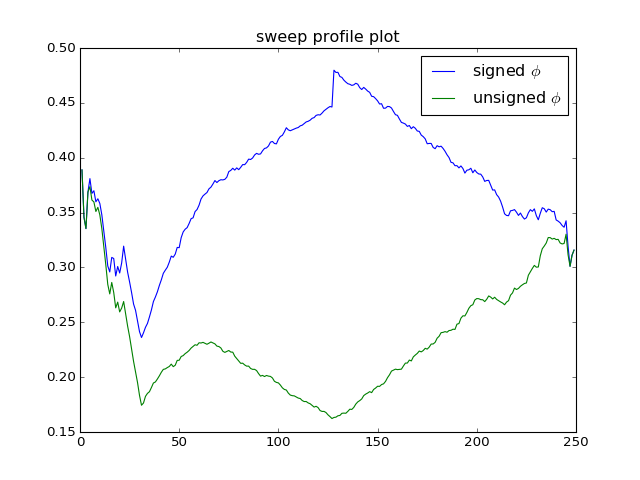

f1 (signed) =  0.8928571428571428
f1 (unsigned) =  0.3289473684210526


In [140]:
g, groundtruth = make(25, 10, 0.8, 0.1, 0.2, 1-0.2)
node2comm = {n: c for c, comm in enumerate(groundtruth) for n in comm}
g_new = transform_via_selfloop_rewiring(g)
ps, rs, fs, sweep_positions, sweep_scores_signed = run_experiment(
    g, g_new, 0, alpha, groundtruth, node2comm, verbose=True, debug=True, 
    use_signed_conductance=True
)

pu, ru, fu, sweep_positions, sweep_scores_unsigned = run_experiment(
    g, g_new, 0, alpha, groundtruth, node2comm, verbose=True, debug=True, 
    use_signed_conductance=False
)


fig, ax = plt.subplots(1, 1)
ax.plot(sweep_positions, sweep_scores_signed)
ax.plot(sweep_positions, sweep_scores_unsigned)

ax.set_title('sweep profile plot')
ax.legend(['signed $\phi$', 'unsigned $\phi$'], loc='best')
print('f1 (signed) = ', fs)
print('f1 (unsigned) = ', fu)

In [119]:
alpha = 0.85

def run_experiment(
    g, g_new, query, alpha, groundtruth, node2comm, verbose=False, debug=False,
    use_signed_conductance=True
):
    """
    prec, rec, f1 = run_experiment(g_new, q, alpha, groundtruth, node2comm)
    """
    if use_signed_conductance:
        order, sweep_positions, sweep_scores = sweeping_scores_using_ppr(
            g_new, query, alpha, 
            A=nx.adjacency_matrix(g_new), 
            signed_A=nx.adjacency_matrix(g, weight='sign'),
            conductance_measure='signed'
        )
    else:
        order, sweep_positions, sweep_scores = sweeping_scores_using_ppr(
            g_new, query, alpha, A=nx.adjacency_matrix(g_new),
            conductance_measure='unsigned'
        )
        
    best_pos = np.argmin(sweep_scores)

    pred_comm = np.zeros(g_new.number_of_nodes())
    pred_comm[order[:best_pos+1]] = 1

    true_comm = np.zeros(g_new.number_of_nodes())
    true_comm[groundtruth[node2comm[query]]] = 1


    prec, rec, f1, supp = precision_recall_fscore_support(true_comm, pred_comm, average=None)
    if debug:
        return prec[1], rec[1], f1[1], sweep_positions, sweep_scores
    else:
        return prec[1], rec[1], f1[1]

In [118]:
def experiment_under_config(
    internal_neg_ratio = 0.2, external_pos_ratio = 0.1, rep=10,
    use_signed_conductance=True
):
    eval_results = []
    noisy_levels = []
    for _ in tqdm(range(rep), total=rep):
        g, groundtruth = make(25, 10, 0.8, internal_neg_ratio, 0.2, 1-external_pos_ratio)
        node2comm = {n: c for c, comm in enumerate(groundtruth) for n in comm}
        
        g_new = transform_via_selfloop_rewiring(g)        

        eval_results += [run_experiment(g, g_new, q, alpha, groundtruth, node2comm,
                                        use_signed_conductance=use_signed_conductance)
                         for q in g.nodes()]
        
        noisy_levels.append(noisy_level(g))
        
    eval_df = pd.DataFrame(eval_results, columns=['prec', 'rec', 'f1'])
    runtime = dict(
        internal_neg_ratio=internal_neg_ratio,
        external_pos_ratio=external_pos_ratio,
        rep=rep,
        noisy_levels=noisy_levels
    )
    return eval_df.describe(), runtime

In [120]:
use_signed_conductance = False
all_results = Parallel(n_jobs=-1)(
    delayed(experiment_under_config)(internal_neg_ratio=inr, external_pos_ratio=epr, rep=10,
                                     use_signed_conductance=use_signed_conductance)
    for inr in make_range(0.1, 0.5)
    for epr in make_range(0.1, 0.5)
)
rows = []
for summ, runtime in all_results:
    rows.append(
        (summ['prec']['mean'], summ['rec']['mean'], summ['f1']['mean'], runtime['external_pos_ratio'], runtime['internal_neg_ratio'], np.mean(runtime['noisy_levels']))
    )
eval_df = pd.DataFrame(rows, columns=['prec', 'rec', 'f1', 'ext_pos_ratio', 'int_neg_ratio', 'noise_level'])
eval_df.to_pickle('outputs/eval_results_community_graph_n25_k10_signed={}.pkl'.format(use_signed_conductance))

  0%|          | 0/10 [00:00<?, ?it/s]/home/cloud-user/code/signed/helpers.py:479: RuntimeWarning: invalid value encountered in true_divide
/home/cloud-user/code/signed/helpers.py:479: RuntimeWarning: invalid value encountered in true_divide
/home/cloud-user/code/signed/helpers.py:479: RuntimeWarning: invalid value encountered in true_divide
/home/cloud-user/code/signed/helpers.py:479: RuntimeWarning: invalid value encountered in true_divide
/home/cloud-user/code/signed/helpers.py:479: RuntimeWarning: invalid value encountered in true_divide
/home/cloud-user/code/signed/helpers.py:479: RuntimeWarning: invalid value encountered in true_divide
/home/cloud-user/code/signed/helpers.py:479: RuntimeWarning: invalid value encountered in true_divide
/home/cloud-user/code/signed/helpers.py:479: RuntimeWarning: invalid value encountered in true_divide
100%|██████████| 10/10 [02:12<00:00, 13.01s/it]


In [121]:
df_signed = pd.read_pickle('outputs/eval_results_community_graph_n25_k10_signed=True.pkl')
df_unsigned = pd.read_pickle('outputs/eval_results_community_graph_n25_k10_signed=False.pkl')

<IPython.core.display.Javascript object>


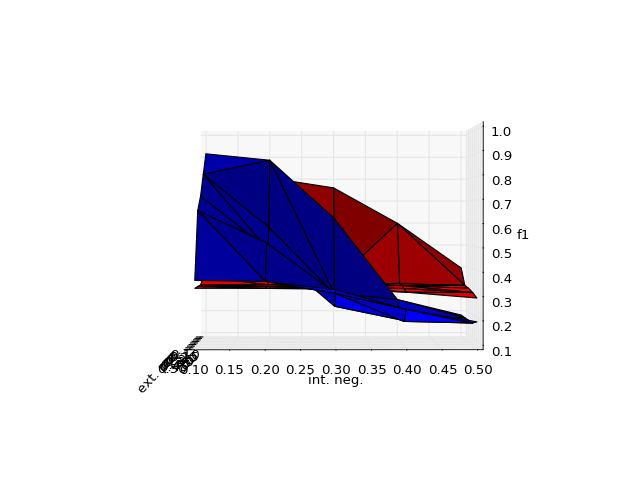

In [134]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

aspect = 'f1'
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(df_signed['ext_pos_ratio'], df_signed['int_neg_ratio'], df_signed[aspect])
ax.plot_trisurf(df_unsigned['ext_pos_ratio'], df_unsigned['int_neg_ratio'], df_unsigned[aspect], color='red')
ax.set_xlabel('ext. pos.')
ax.set_ylabel('int. neg.')
# ax.legend(['sweep on signed conductance', 'sweep on conductance'])
ax.set_zlabel(aspect)

# sanity check: small graphs

<IPython.core.display.Javascript object>


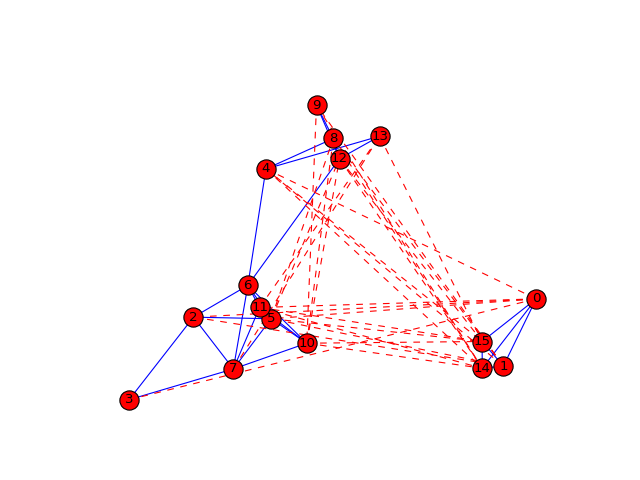

In [170]:
graph_name = 'tribe'
g = nx.read_gpickle('graphs/{}.pkl'.format(graph_name))
g_new = transform_via_selfloop_rewiring(g)

fig, ax = get_borderless_fig()
pos = signed_layout(g)
    
draw_nodes(g, pos, ax=ax)
# nx.draw_networkx_nodes(g, pos, node_size=100)
draw_edges(g, pos, ax=ax)


In [171]:
def show_detected_community(query):
    order, sweep_positions, sweep_scores = sweeping_scores_using_ppr(
            g_new, query, alpha, 
            A=nx.adjacency_matrix(g_new), 
            signed_A=nx.adjacency_matrix(g, weight='sign'),
            conductance_measure='signed'
        )

    best_pos = np.argmin(sweep_scores)

    comm = order[:best_pos+1]

    pal = sns.color_palette('hls', 8)

    node_color = np.zeros((g.number_of_nodes(), 3))
    for i in np.arange(g.number_of_nodes()):
        if i in comm:
            node_color[i] = pal[3]
        else:
            node_color[i] = pal[1]


    fig, ax = get_borderless_fig()    
    nx.draw_networkx_nodes(g, pos, node_color=node_color, node_size=100, ax=ax)
    draw_edges(g, pos, ax=ax)
    ax.set_title('detected community w.r.t query {} (green)'.format(query))
    # fig.savefig(fig_dir + '/subgraph-selection.' + FIG_FORMAT)

/home/cloud-user/code/signed/helpers.py:453: RuntimeWarning: invalid value encountered in true_divide
  


<IPython.core.display.Javascript object>


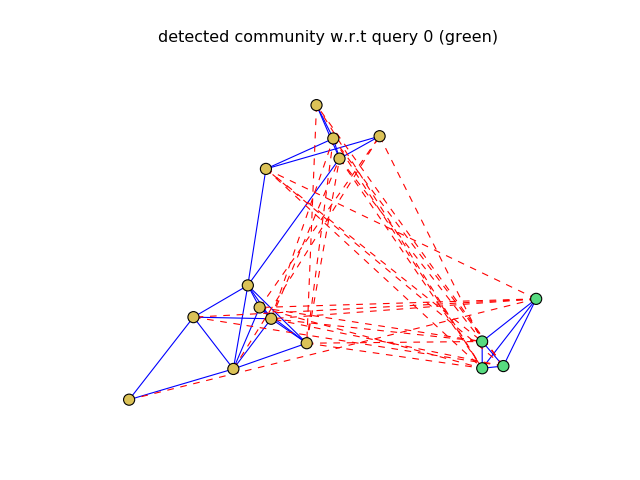

<IPython.core.display.Javascript object>


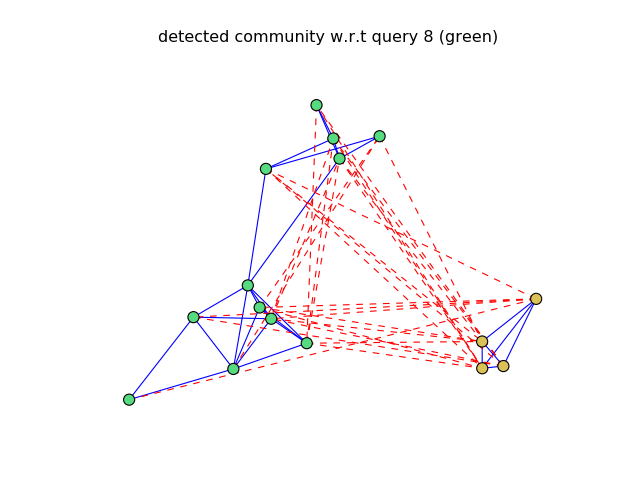

<IPython.core.display.Javascript object>


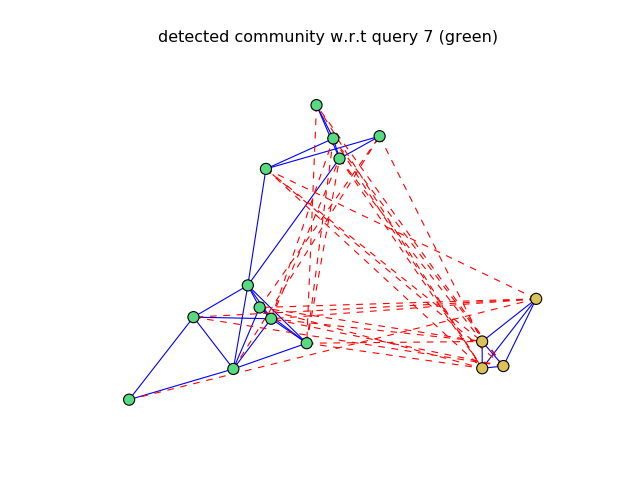

In [172]:
if graph_name == 'tribe':
    show_detected_community(0)
    show_detected_community(8)
    show_detected_community(7)
elif graph_name == 'cloister':
    show_detected_community(16)
    show_detected_community(12)
    show_detected_community(6)
elif graph_name == 'congress':
    show_detected_community(91)
    show_detected_community(33)
    show_detected_community(7)

    

# sanity check: middly-sized graphs

In [173]:
g = nx.read_gpickle('graphs/bitcoin.pkl')
g_new = transform_via_selfloop_rewiring(g)

In [176]:
def run_experiment_given_query(query):
    order, sweep_positions, sweep_scores = sweeping_scores_using_ppr(
            g_new, query, alpha, 
            A=nx.adjacency_matrix(g_new), 
            signed_A=nx.adjacency_matrix(g, weight='sign'),
            conductance_measure='signed'
        )

    best_pos = np.argmin(sweep_scores)

    comm = order[:best_pos+1]
    return query, comm

In [177]:
res = Parallel(n_jobs=-1)(delayed(run_experiment_given_query)(query)
                          for query in tqdm(g.nodes(), total=g.number_of_nodes()))


  0%|          | 0/5881 [00:00<?, ?it/s]







  0%|          | 1/5881 [00:00<34:09,  2.87it/s]
/home/cloud-user/code/signed/helpers.py:453: RuntimeWarning: invalid value encountered in true_divide
  scores = (pos_penalty + neg_penalty_selected) / vols
/home/cloud-user/code/signed/helpers.py:453: RuntimeWarning: invalid value encountered in true_divide
  scores = (pos_penalty + neg_penalty_selected) / vols

  0%|          | 16/5881 [00:00<25:05,  3.89it/s]/home/cloud-user/code/signed/helpers.py:453: RuntimeWarning: invalid value encountered in true_divide
  scores = (pos_penalty + neg_penalty_selected) / vols
/home/cloud-user/code/signed/helpers.py:453: RuntimeWarning: invalid value encountered in true_divide
  scores = (pos_penalty + neg_penalty_selected) / vols
/home/cloud-user/code/signed/helpers.py:453: RuntimeWarning: invalid value encountered in true_divide
  scores = (pos_penalty + neg_penalty_selected) / vols
/home/cloud-user/code/signed/helpers.py:453: RuntimeWarning: invali

In [184]:
from eval_helpers import community_summary
A = nx.adjacency_matrix(g, weight='sign')

def evaluate(query, comm):
    summ = community_summary(g.subgraph(comm), g, A=A)
    summ['query'] = query
    summ['comm'] = comm
    return summ
    
eval_res = Parallel(n_jobs=-1)(delayed(evaluate)(query, comm)
                               for query, comm in tqdm(res))

100%|██████████| 5881/5881 [00:38<00:00, 154.68it/s]


In [205]:
eval_df = pd.DataFrame.from_records(eval_res)

In [206]:
# eval_df = eval_df[eval_df['n'] > 1500]
eval_df.sort_values(by='n', ascending=True)

,n,m,edge_agreement_ratio,query,comm
3788,1,0,0.150807,3788,[3788]
5055,1,0,0.150827,5055,[5055]
5056,1,0,0.150788,5056,[5056]
5057,1,0,0.150807,5057,[5057]
1710,1,0,0.150709,1710,[1710]
4190,1,0,0.150788,4190,[4190]
5059,1,0,0.150827,5059,[5059]
5060,1,0,0.150807,5060,[5060]
5061,1,0,0.150827,5061,[5061]
4657,1,0,0.150570,4657,[4657]


<IPython.core.display.Javascript object>


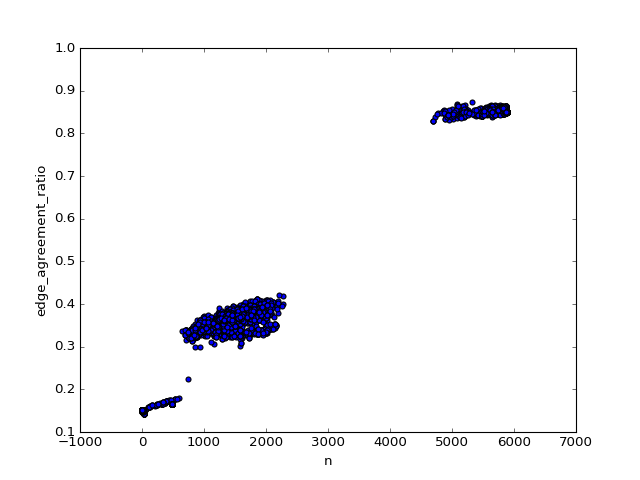

In [207]:
eval_df.plot(x='n', y='edge_agreement_ratio', kind='scatter')

In [209]:
eval_df.to_pickle('outputs/eval_results_{}_signed=True.pkl'.format(graph_name))

# check on thesaurus graph

In [216]:
g = nx.read_gpickle('graphs/thesaurus.pkl')
g_new = transform_via_selfloop_rewiring(g)

def run_experiment_given_query_on_thesaurus(query):
    order, sweep_positions, sweep_scores = sweeping_scores_using_ppr(
            g_new, query, alpha, 
            A=nx.adjacency_matrix(g_new), 
            signed_A=nx.adjacency_matrix(g, weight='sign'),
            conductance_measure='signed'
        )

    best_pos = np.argmin(sweep_scores)

    comm = order[:best_pos+1]
    w2i = g.graph['w2i']
    i2w = g.graph['i2w']
    return i2w[query], [i2w[n] for n in comm]

In [233]:
run_experiment_given_query_on_thesaurus(g.graph['w2i']['delicious'])

/home/cloud-user/code/signed/sweeping.py:20: RuntimeWarning: invalid value encountered in true_divide
  node_scores = z_vect / deg
/home/cloud-user/code/signed/helpers.py:453: RuntimeWarning: invalid value encountered in true_divide
  scores = (pos_penalty + neg_penalty_selected) / vols


('delicious',
 ['delicious',
  'sweet',
  'appetizing',
  'heavenly',
  'exquisite',
  'enjoyable',
  'delightful',
  'blissful',
  'luscious',
  'impeccable',
  'delectable',
  'gratifying',
  'angelic',
  'subtle',
  'ethereal',
  'pleasurable',
  'likable',
  'tempting',
  'yummy',
  'fun',
  'satisfying',
  'amusing',
  'entertaining',
  'lovely',
  'divine',
  'admirable',
  'sublime',
  'tasty',
  'savory',
  'superb',
  'supernatural',
  'juicy',
  'delicate',
  'elegant',
  'fascinating',
  'succulent',
  'beautiful',
  'intangible',
  'pleasing',
  'pleasant',
  'celestial',
  'diverting',
  'transcendent',
  'saintly',
  'immaculate',
  'mellow',
  'opulent',
  'humorous',
  'holy',
  'enchanting',
  'seductive',
  'tender',
  'handsome',
  'profound',
  'lush',
  'compelling',
  'superlative',
  'enticing',
  'spiritual',
  'sumptuous',
  'superhuman',
  'psychic',
  'exalted',
  'fine',
  'funny',
  'pretty',
  'sacred',
  'praiseworthy',
  'commendable',
  'engaging',
  'g

In [221]:
thesaurus_res = Parallel(n_jobs=-1)(delayed(run_experiment_given_query_on_thesaurus)(query)
                          for query in tqdm(g.nodes(), total=g.number_of_nodes()))

  0%|          | 1/15670 [00:00<1:54:29,  2.28it/s]/home/cloud-user/code/signed/sweeping.py:20: RuntimeWarning: invalid value encountered in true_divide
  node_scores = z_vect / deg
/home/cloud-user/code/signed/sweeping.py:20: RuntimeWarning: invalid value encountered in true_divide
  node_scores = z_vect / deg
/home/cloud-user/code/signed/sweeping.py:20: RuntimeWarning: invalid value encountered in true_divide
  node_scores = z_vect / deg
/home/cloud-user/code/signed/sweeping.py:20: RuntimeWarning: invalid value encountered in true_divide
  node_scores = z_vect / deg
/home/cloud-user/code/signed/sweeping.py:20: RuntimeWarning: invalid value encountered in true_divide
  node_scores = z_vect / deg
/home/cloud-user/code/signed/sweeping.py:20: RuntimeWarning: divide by zero encountered in true_divide
  node_scores = z_vect / deg
/home/cloud-user/code/signed/sweeping.py:20: RuntimeWarning: invalid value encountered in true_divide
  node_scores = z_vect / deg
/home/cloud-user/code/signed/sw

KeyboardInterrupt: 